### 6 m is mean nitricline depth and just below 10% light level

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import glob
import datetime as dt
from salishsea_tools import viz_tools
from matplotlib.ticker import FormatStrFormatter
import cmocean
from salishsea_tools import viz_tools, evaltools as et
import NorthNut as nn
import matplotlib.gridspec as gridspec
import pickle
import matplotlib as mpl
import matplotlib.patheffects as path_effects
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

NorthNut defined variables: ig0,ig1,jg0,jg1,fformat0
NorthNut defined variables: vmask, vmask0, umask, umask0, tmask, fmask, gdept,  gdept_1d, e1t, e2t, e12t, e1f, e2f, e1v, e2u, e3t_1d
NorthNut defined variables: boxCol, colL, colR, arrowwidth, headwidth, headlength, alen, toff, apw, apk


In [2]:
ig0=nn.ig0
ig1=nn.ig1
jg0=nn.jg0
jg1=nn.jg1
tmask=nn.tmask
umask=nn.umask
vmask=nn.vmask
umask0=nn.umask0
vmask0=nn.vmask0
boxCol=nn.boxCol
colL=nn.colL
colR=nn.colR

In [3]:
e12t=nn.e12t

In [4]:
k=6 #depth presented here
k1=30 # max depth to do calcs to
start=dt.datetime(2015,5,15) # originally 5/15-8/15,  but changed to even number of fortnights (6, end is included)
end=dt.datetime(2015,8,20)
mod_basedir='/data/eolson/results/MEOPAR/SS36runs/CedarRuns/rev_noDisc/'
mod_nam_fmt='long'
mod_flen=10
saveloc='/data/eolson/results/MEOPAR/SS36runs/calcFiles/NTransport/'
fver='noDisc'

In [5]:
tmask.shape

(40, 130, 97)

In [6]:
tmask2=np.expand_dims(tmask,0)
tmask2.shape

(1, 40, 130, 97)

In [8]:
t0=start
te=end
fformat0='%Y%m%d'
recalc=True

fliste3t=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'ptrc_T',1)
flistPP=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'prod_T',1)

In [10]:
savepath=saveloc+'IPP_'+fver+'_'+t0.strftime(fformat0)+'-'+te.strftime(fformat0)+'.pkl'
times=[t0+dt.timedelta(hours=ii) for ii in range(0,int((te-t0).total_seconds()/3600)+24)]
if recalc==True:
    ## calculations
    tf0=flistPP.loc[0,['t_0']].values[0]
    tfe=flistPP.loc[len(flistPP)-1,['t_n']].values[0]-dt.timedelta(days=1)
    IPPx=np.empty((int((tfe-tf0).days*24+24),jg1-jg0,ig1-ig0))
    INPPx=np.empty((int((tfe-tf0).days*24+24),jg1-jg0,ig1-ig0))
    iii0=int((t0-tf0).total_seconds()/3600)
    iiie=int((te-tf0).days*24+24)
    ti=t0
    for iif in range(0,len(flistPP)):
        li0=iif*mod_flen*24
        li1=(iif+1)*mod_flen*24
        with nc.Dataset(flistPP.loc[iif,['paths']].values[0]) as fPP, \
                nc.Dataset(fliste3t.loc[iif,['paths']].values[0]) as fe3t:
            IPPx[li0:li1,...]=np.sum(tmask2*\
                    (fPP.variables['PPDIAT'][:,:,jg0:jg1,ig0:ig1]+fPP.variables['PPPHY'][:,:,jg0:jg1,ig0:ig1]+fPP.variables['PPMRUB'][:,:,jg0:jg1,ig0:ig1])*\
                                 fe3t.variables['e3t'][:,:,jg0:jg1,ig0:ig1],1)
            INPPx[li0:li1,...]=np.sum(tmask2*\
                    (fPP.variables['PPDIATNO3'][:,:,jg0:jg1,ig0:ig1]+fPP.variables['PPPHYNO3'][:,:,jg0:jg1,ig0:ig1]+fPP.variables['PPMRUBNO3'][:,:,jg0:jg1,ig0:ig1])*\
                                 fe3t.variables['e3t'][:,:,jg0:jg1,ig0:ig1],1)

    #constrain to correct times
    IPP=IPPx[iii0:iiie,...]
    INPP=INPPx[iii0:iiie,...]
    data=dict()
    data['IPP']=IPP
    data['INPP']=INPP
    pickle.dump(data,open(savepath,'wb'))
else:
    data=pickle.load(open(savepath,'rb'))
    IPP=data['IPP']
    INPP=data['INPP']

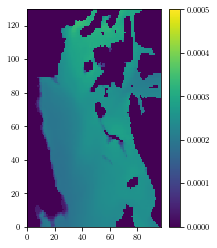

In [15]:
fig,ax=plt.subplots(1,1,figsize=(3,4))
m=ax.pcolormesh(np.mean(IPP,0),vmin=0,vmax=.0005)
fig.colorbar(m)